In [1]:
import tensorflow as tf 
tf.enable_eager_execution()

from tensorflow.keras.backend import clear_session
# https://github.com/keras-team/keras/issues/2102#issuecomment-233773649
clear_session() 

import tensorflow_probability as tfp 
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

# Load data -- graph of a [cardioid](https://en.wikipedia.org/wiki/Cardioid).
n = 2000
t = tfd.Uniform(low=-np.pi, high=np.pi).sample([n, 1])
r = 2 * (1 - tf.cos(t))
x = r * tf.sin(t) + tfd.Normal(loc=0., scale=0.1).sample([n, 1])
y = r * tf.cos(t) + tfd.Normal(loc=0., scale=0.1).sample([n, 1])

# Model the distribution of y given x with a Mixture Density Network.
output_shape = (1,)
number_components = 5
number_distribution_parameters = tfpl.MixtureSameFamily.params_size(
    number_components,
    tfpl.IndependentNormal.params_size(output_shape))
regularization_strength = 0.01
model = tfk.Sequential([
    tfkl.Dense(12, activation='relu', input_shape=(1,), kernel_regularizer=tfk.regularizers.l2(regularization_strength)),
    tfkl.Dense(number_distribution_parameters, activation=None, kernel_regularizer=tfk.regularizers.l2(regularization_strength)),
    tfpl.MixtureSameFamily(number_components, tfpl.IndependentNormal(output_shape)),
])

# Fit.
batch_size = 100
model.compile(optimizer=tf.train.AdamOptimizer(learning_rate=0.02),
              loss=lambda y, d: -d.log_prob(y))
history = model.fit(x, y,
                    batch_size=batch_size,
                    epochs=20,
                    steps_per_epoch=n // batch_size)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
20/20 [==============================] - 0s 10ms/step - loss: 2.1953
Epoch 2/20
20/20 [==============================] - 0s 2ms/step - loss: 1.5923
Epoch 3/20
20/20 [==============================] - 0s 2ms/step - loss: 1.2411
Epoch 4/20
20/20 [==============================] - 0s 2ms/step - loss: 0.9190
Epoch 5/20
20/20 [==============================] - 0s 2ms/step - loss: 0.6547
Epoch 6/20
20/20 [==============================] - 0s 2ms/step - loss: 0.5290
Epoch 7/20
20/20 [==============================] - 0s 2ms/step - loss: 0.4684
Epoch 8/20
20/20 [==========

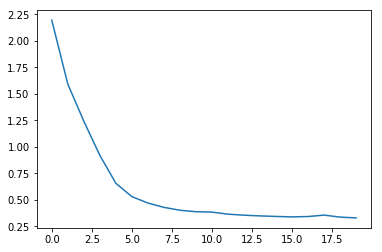

In [2]:
plt.plot(history.epoch, history.history['loss'])

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                24        
_________________________________________________________________
dense_1 (Dense)              (None, 15)                195       
_________________________________________________________________
mixture_same_family (Mixture [(None, 1), (None, 1)]    0         
Total params: 219
Trainable params: 219
Non-trainable params: 0
_________________________________________________________________


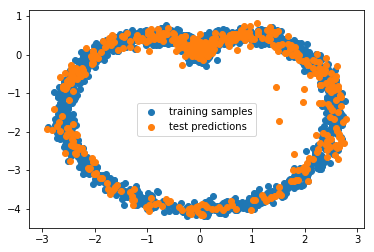

In [4]:
n = 500
t = tfd.Uniform(low=-np.pi, high=np.pi).sample([n, 1])
r = 2 * (1 - tf.cos(t))
x_test = r * tf.sin(t) + tfd.Normal(loc=0., scale=0.1).sample([n, 1])

plt.scatter(x, y, label='training samples')
plt.scatter(x_test, model(x_test).sample(), label='test predictions')
plt.legend()

In [5]:
model.inputs

[<tf.Tensor 'dense_input:0' shape=(?, 1) dtype=float32>]

In [6]:
inputs = np.zeros((1, 1))
inputs.dtype

dtype('float64')

In [7]:
inputs = np.zeros((1, 1), dtype=np.float32)

In [8]:
outputs = model(inputs) # predicted distribution
outputs

<tfp.distributions.MixtureSameFamily 'sequential/mixture_same_family/mixture_same_family/MixtureSameFamily/MixtureSameFamily/' batch_shape=(1,) event_shape=(1,) dtype=float32>

In [9]:
outputs.mixture_distribution.probs # priors

<tf.Tensor: id=2974, shape=(1, 5), dtype=float32, numpy=
array([[0.00130975, 0.00339582, 0.1510642 , 0.84107727, 0.00315295]],
      dtype=float32)>

In [10]:
outputs.components_distribution.distribution.loc # means

<tf.Tensor: id=2928, shape=(1, 5, 1), dtype=float32, numpy=
array([[[-0.17083636],
        [-0.8802318 ],
        [-4.029192  ],
        [ 0.10000342],
        [ 0.10655487]]], dtype=float32)>

In [11]:
outputs.components_distribution.distribution.scale # standard deviations

<tf.Tensor: id=2930, shape=(1, 5, 1), dtype=float32, numpy=
array([[[0.73718333],
        [0.61662334],
        [0.09422307],
        [0.13523781],
        [0.23760518]]], dtype=float32)>

In [12]:
training_joint_distribution = tfd.Independent(model(x), reinterpreted_batch_ndims=1)
training_joint_distribution

<tfp.distributions.Independent 'Independentsequential/mixture_same_family/mixture_same_family/MixtureSameFamily/MixtureSameFamily/' batch_shape=() event_shape=(2000, 1) dtype=float32>

In [13]:
training_log_likelihood = training_joint_distribution.log_prob(y)
-training_log_likelihood/len(x)

<tf.Tensor: id=3331, shape=(), dtype=float32, numpy=0.14779587>

In [14]:
history.history['loss'][-1]

0.32790812402963637

The above difference between `history.history['loss'][-1]` and `-training_log_likelihood/len(x)` is due to L2 regularization, as you can see by setting `regularization_strength` to zero. 